# P-Dispersion (max-min-min) Problem

*Authors:* [Erin Olson](https://github.com/erinrolson), [James Gaboardi](https://github.com/jGaboardi), [Levi J. Wolf](https://github.com/ljwolf), [Qunshan Zhao](https://github.com/qszhao)

Kuby (1987) described the following problem:

_Locate p facilities on a network so that the minimum distance between any pair of facilities is maximized._ Kuby (1987)

**P-Dispersion can be written as:**

\begin{equation*}
\textbf{Maximize }D 
\end{equation*}

_Subject to:_
\begin{equation*}
\sum_{i=1}^{n} Y_i = p 
\end{equation*}

\begin{equation*}
D \leq d_{ij} + M (2 - Y_{i} - Y_{j}), \quad \forall i; \forall j > i 
\end{equation*}

\begin{equation*}
Y_i = \{0,1\}, \quad \forall i 
\end{equation*}

_Where:_

\begin{array}{lclll}
& & i,j & \small = & \textrm{index of potential facility sites} \\
& & n & \small = & \textrm{number of potential facility sites} \\
& & d_{ij} & \small = & \textrm{shortest path distance between sites} \quad i \quad \textrm{and} \quad j \\
& & M & \small = & \textrm{some large number; such that} \quad M \geq \textrm{max}_{ij}\{d_{ij}\} \\
& & p & \small = & \textrm{number of facilities to be located} \\
& & Y_i & \small = & \begin{cases} 
          1 \quad \text{if facility is located at node} \quad i\\
          0 \quad \text{if otherwise} \\
       \end{cases} \end{array}




_The above fomulation was quoted from (Maliszewski et al 2012), the original formulation is from (Kuby 1987)._ 


This tutorial solves for P-Dispersion using `spopt.locate.p_dispersion.PDispersion` instance that depends on a 2D array representing the costs between facility candidate sites. Costs are calculated from a 10x10 lattice with simulated points.

In [355]:
from spopt.locate.p_dispersion import PDispersion
from spopt.locate.util import simulated_geo_points

import numpy
import geopandas
import pulp
import spaghetti
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [356]:
FACILITY_COUNT = 4 # quantity supply points

# Random seeds for reproducibility
FACILITY_SEED = 6

solver = pulp.PULP_CBC_CMD(msg=False, warmStart=True)

## Lattice 10x10

Create a 10x10 lattice with 9 vertical lines in the interior.

In [357]:
lattice = spaghetti.regular_lattice((0, 0, 10, 10), 9, exterior=True)
ntw = spaghetti.Network(in_data=lattice)

Transform the spaghetti instance into a geodataframe.

In [358]:
street = spaghetti.element_as_gdf(ntw, arcs=True)

street_buffered = geopandas.GeoDataFrame(
    geopandas.GeoSeries(street["geometry"].buffer(0.2).unary_union),
    crs=street.crs,
    columns=["geometry"],
)

By plotting the network created by spaghetti we can verify the simulation of a district with quarters and streets.

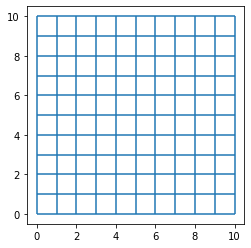

In [359]:
street.plot()

## Simulate points in a network

The function `simulated_geo_points` simulates points inside a network. In this case, it uses a lattice network 10x10 created using the spaghetti package. 
Below we use the function defined above and simulate the points inside the lattice bounds.

In [360]:
facility_points = simulated_geo_points(
    street_buffered, needed=FACILITY_COUNT, seed=FACILITY_SEED
)

Plotting the 4 facility points we can see that the function generates dummy points to an area of 10x10 which is the area created by our lattice created on previous cells.

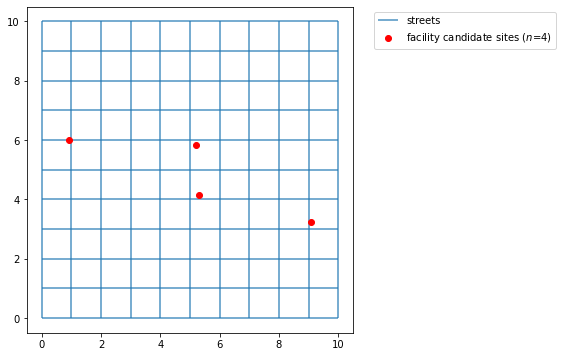

In [361]:
fig, ax = plt.subplots(figsize=(6, 6))
street.plot(ax=ax, alpha=0.8, zorder=1, label='streets')
facility_points.plot(ax=ax, color='red', zorder=2, label='facility candidate sites ($n$=4)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

## Transform simulated points to real points

To use a cost matrix or geodataframes we have to pay attention to certain details. The facility points simulated don't currently belong to a network, so if we calculate the network distances between facilities now we would receive an incorrect result. Before calculating distances we must snap points to the network and then calculate the distances.

Below we snap points to the lattice created above and create new real points geodataframes.

In [362]:
ntw.snapobservations(facility_points, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="facilities", snapped=True
)

The plot is now visually more organized as the points belong to a network. 
The network created is plotted below:

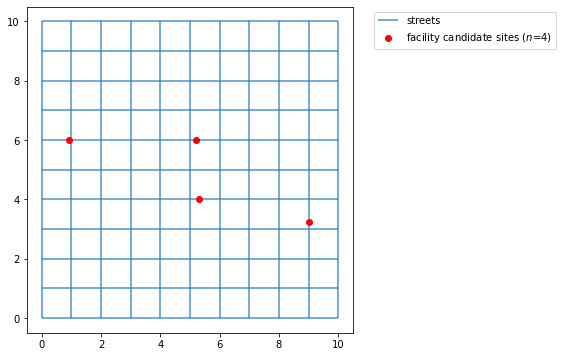

In [363]:
fig, ax = plt.subplots(figsize=(6, 6))
street.plot(ax=ax, alpha=0.8, zorder=1, label='streets')
facilities_snapped.plot(ax=ax, color='red', zorder=2, label='facility candidate sites ($n$=4)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

## Calculating the cost matrix 

Calculate the distance between facilities.

In [364]:
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["facilities"],
    destpattern=ntw.pointpatterns["facilities"]
)

The expected result is a Dijkstra distance between facilities, so in our case an array 2D 4x4.

In [365]:
cost_matrix

array([[ 0.        , 10.82778055,  4.43730946,  6.55983134],
       [10.82778055,  0.        ,  6.3904711 ,  4.26794921],
       [ 4.43730946,  6.3904711 ,  0.        ,  2.49767925],
       [ 6.55983134,  4.26794921,  2.49767925,  0.        ]])

All code before this is pre-problem setup. Now with the information we have we must create a PuLP problem and use the PuLP solver to solve for P-Dispersion.

In [366]:
#number of facilities to be sited
p = 2

disperse_from_cost_matrix = PDispersion.from_cost_matrix(cost_matrix, p)
disperse_from_cost_matrix = disperse_from_cost_matrix.solve(solver)

The expected result is an instance of PDispersion.

In [367]:
disperse_from_cost_matrix

Verify which locations have been selected.

In [368]:
print('\n'+ 'Chosen Facility Values:')
for i in disperse_from_cost_matrix.fac_vars:
    if i.varValue == 1:
        print(i,i.varValue)


Chosen Facility Values:
y_0_ 1.0
y_1_ 1.0


Retreive the value of the maximization function.

In [369]:
print('Maximization Variable: ',disperse_from_cost_matrix.disperse_var, disperse_from_cost_matrix.disperse_var.varValue)

Maximization Variable:  D 10.827781


## Solve for P-Dispersion using a GeoDataFrame with Predefined Facilities

Assign a predefined location using a geodataframe column.

In [370]:
predefined_facilities_snapped = facilities_snapped.copy()
predefined_facilities_snapped['predefined_loc'] = numpy.array([0, 0, 0, 1])

predefined_facilities_snapped

,id,geometry,comp_label,predefined_loc
0,0,POINT (9.00000 3.25259),0,0
1,1,POINT (0.91963 6.00000),0,0
2,2,POINT (5.31010 4.00000),0,0
3,3,POINT (5.18758 6.00000),0,1


In [371]:
#number of facilities to be sited
p = 2

disperse_from_geodataframe = PDispersion.from_geodataframe(predefined_facilities_snapped, "geometry", p, predefined_facility_col="predefined_loc", distance_metric="euclidean")
disperse_from_geodataframe = disperse_from_geodataframe.solve(solver)

Expected result is an instance of PDispersion.

In [372]:
disperse_from_geodataframe

Verify which locations have been selected.

In [373]:
print('\n'+ 'Chosen Facility Values:')
for i in disperse_from_geodataframe.fac_vars:
    if i.varValue == 1:
        print(i,i.varValue)


Chosen Facility Values:
y_0_ 1.0
y_3_ 1.0


Retreive the value of the maximization function.

In [374]:
print('Maximization Variable: ', disperse_from_geodataframe.disperse_var, disperse_from_geodataframe.disperse_var.varValue)

Maximization Variable:  D 4.6992359


## Plot results

Below plot is for testing 

In [375]:
from matplotlib.patches import Patch
import matplotlib.lines as mlines

dv_colors = [
    "darkslategray",
    "lightskyblue",
    "limegreen",
    "darkgoldenrod",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "thistle",
    "lavender",
    "saddlebrown",
    "darkcyan",
    "mediumseagreen",
    "cyan",
]

pre_colors = [
    "darkcyan",
    "mediumseagreen",
    "cyan",
]

def plot_results(model, facility_points, title):
    fac_sites = []
    
    for i in range(FACILITY_COUNT):
        if model.fac_vars[i].varValue == 1:
            fac_sites.append(i)
    sited_facilities = range(len(fac_sites))

    fig, ax = plt.subplots(figsize=(6, 6))
    legend_elements = []

    street.plot(ax=ax, alpha=1, color='black', zorder=1)
    legend_elements.append(mlines.Line2D(
        [],
        [],
        color='black',
        label='streets',
    ))

    facility_points.plot(ax=ax, color='brown', marker="*", markersize=80, zorder=2)
    legend_elements.append(mlines.Line2D(
        [],
        [],
        color='brown',
        marker="*",
        linewidth=0,
        label=f'facility sites ($n$={FACILITY_COUNT})'
    ))

    if 'predefined_loc' in facility_points.columns:
        pdf_ind = facility_points[facility_points['predefined_loc'] == 1].index.values 
        pre_fac = facility_points[facility_points.predefined_loc == 1]
        for i in range(len(pre_fac)):
            pre_fac.iloc[[i]].plot(ax=ax,
                        marker="*",
                        markersize=200 * 3.0,
                        alpha=0.8,
                        zorder=4,
                        edgecolor="red",
                        facecolor=pre_colors[i])


        for i in sited_facilities:
            if fac_sites[i] not in pdf_ind:
                facility_points.iloc[[fac_sites[i]]].plot(ax=ax,
                                    marker="*",
                                    markersize=200 * 3.0,
                                    alpha=0.8,
                                    zorder=4,
                                    edgecolor="k",
                                    facecolor=dv_colors[i])
            
        for i in range(len(pre_fac)):

            legend_elements.append(mlines.Line2D(
            [],
            [],
            color=pre_colors[i],
            marker="*",
            ms=20 / 2,
            markeredgecolor="red",
            linewidth=0,
            alpha=0.8,
            label=f"y_{pdf_ind[i]} (predefined) facility selected",
        ))

        for i in sited_facilities: 
            

            fac = fac_sites[i] 
            if fac in pdf_ind:
                continue
            else:
                legend_elements.append(mlines.Line2D(
                [],
                [],
                color=dv_colors[i],
                marker="*",
                ms=20 / 2,
                markeredgecolor="k",
                linewidth=0,
                alpha=0.8,
                label=f"y_{fac_sites[i]} facility selected",
            ))
    else:
        for i in sited_facilities:

            facility_points.iloc[[fac_sites[i]]].plot(ax=ax,
                                    marker="*",
                                    markersize=200 * 3.0,
                                    alpha=0.8,
                                    zorder=4,
                                    edgecolor="k",
                                    facecolor=dv_colors[i])
            
        for i in sited_facilities:
            legend_elements.append(mlines.Line2D(
            [],
            [],
            color=dv_colors[i],
            marker="*",
            ms=20 / 2,
            markeredgecolor="k",
            linewidth=0,
            alpha=0.8,
            label=f"y{fac_sites[i]} facility selected",
        ))

    plt.title(title, fontweight="bold")
    plt.legend(handles = legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))

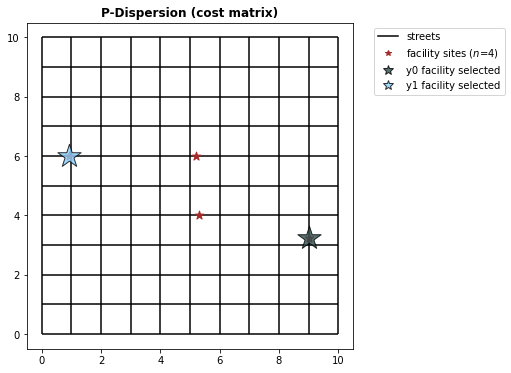

In [376]:
plot_results(disperse_from_cost_matrix, facilities_snapped, 'P-Dispersion (cost matrix)')

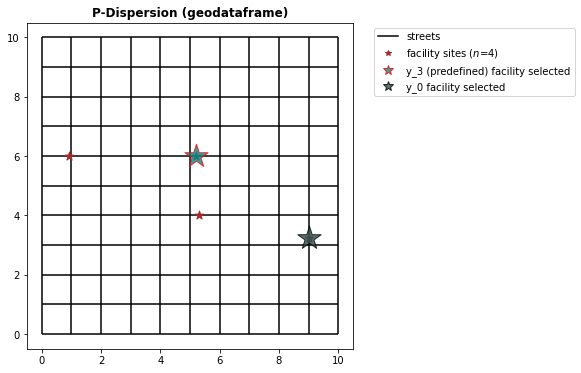

In [377]:
plot_results(disperse_from_geodataframe, predefined_facilities_snapped, 'P-Dispersion (geodataframe)')

## References

- [Kuby, Michael J. 1987. Programming Models for Facility Dispersion: The p-Dispersion and Maximum Dispersion Problems. Geographical Analysis, 19, 315–329.](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1538-4632.1987.tb00133.x)
- [Maliszewski, Paul J., Michael J. Kuby, and Mark W. Horner. 2012. A comparison of multi-objective spatial dispersion models for managing critical assets in urban areas. Computers, Environment and Urban Systems. 36 (4):331-341.](https://www.sciencedirect.com/science/article/pii/S0198971511001293?via%3Dihub)